# Multilayer Perceptron (MLP) Classifier Demo

This notebook demonstrates the use of a **custom Multilayer Perceptron (MLP) classifier implemented from scratch using NumPy**.  

The goal is to show:
- How a feedforward neural network can be trained for **binary classification**
- The effect of hidden layers and nonlinear activations
- A clean, sklearn-like workflow using a custom implementation

We apply the model to a real-world binary classification dataset and evaluate its predictive performance.


## Mathematical Formulation of a Multilayer Perceptron

A multilayer perceptron consists of a sequence of affine transformations followed by nonlinear activations. 

### Forward Pass

For layer $\ell$, the weighted input $z^{(\ell)}$ and the activation $a^{(\ell)}$ are calculated as:

$$
z^{(\ell)} = a^{(\ell-1)} W^{(\ell)} + b^{(\ell)}
$$

$$
a^{(\ell)} = g(z^{(\ell)})
$$

where:
* $W^{(\ell)}$ are the **weights** for layer $\ell$.
* $b^{(\ell)}$ are the **biases** for layer $\ell$.
* $g(\cdot)$ is an **activation function** (e.g., ReLU, Tanh).
* $a^{(0)}$ is the input data, $X$.

---

### Output Layer (Binary Classification)

The final prediction, $\hat{y}$, is the result of the affine transformation on the last hidden layer's activation $a^{(L-1)}$, followed by the sigmoid function $\sigma$:

$$
\hat{y} = \sigma(z^{(L)})
$$

where $\sigma(x) = \frac{1}{1 + e^{-x}}$.

---

### Loss Function

We use the **Binary Cross-Entropy (BCE)** loss, $\mathcal{L}$, to measure the discrepancy between the true target $y$ and the prediction $\hat{y}$:

$$
\mathcal{L}(y, \hat{y}) = -\left(y \log \hat{y} + (1 - y)\log(1 - \hat{y})\right)
$$

---

### Optimization

Parameters ($W$ and $b$) are updated iteratively using **Gradient Descent**:

$$
W \leftarrow W - \eta \nabla_W \mathcal{L}
$$

where $\eta$ is the learning rate.

**L2 Regularization** is often added to the loss function to discourage overly complex models by penalizing large weights:

$$
\mathcal{L}_{total} = \mathcal{L}(y, \hat{y}) + \lambda \|W\|_2^2
$$

where $\lambda$ is the regularization strength.

## Intuition Behind the MLP

Key ideas:
- Each hidden layer learns **nonlinear feature transformations**
- ReLU activations introduce sparsity and piecewise linearity
- Stacking layers enables hierarchical representations

In contrast to logistic regression:
- Logistic regression learns a **single linear decision boundary**
- MLPs learn **compositions of nonlinear functions**

This makes MLPs well-suited for datasets with complex interactions between variables.


## Imports and Setup

We rely exclusively on:
- **NumPy** for numerical computation
- **Pandas** for CSV loading and preprocessing
- **Matplotlib** for visualization
- Custom `rice2025` utilities for:
  - Train–test splitting
  - Feature scaling
  - Neural network modeling

No sklearn models or training utilities are used.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice2025.supervised_learning.multilayer_perceptron import MLPClassifier
from rice2025.utils.train_test_split import train_test_split
from rice2025.utils.scaling import StandardScaler

df = pd.read_csv("insurance.csv")
df.head()



,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


## Dataset: Insurance

The insurance dataset contains demographic and health-related attributes used to model insurance outcomes.

Common variables include:
- `age`
- `sex`
- `bmi`
- `children`
- `smoker`
- `region`
- `expenses`

In this notebook, we formulate a **binary classification task**.


In [12]:
# Convert smoker to binary target
df["smoker"] = df["smoker"].map({"yes": 1, "no": 0})

y = df["smoker"].values
X = df.drop(columns=["smoker", "expenses"])


## Defining the Classification Task

We define the binary target as:

$$
y =
\begin{cases}
1 & \text{if the individual is a smoker} \\
0 & \text{otherwise}
\end{cases}
$$

Why this choice:
* Naturally binary
* Nonlinear interactions (BMI, age, region, children)
* Suitable for demonstrating a neural network classifier

The variable `expenses` is excluded to prevent target leakage.

## Encoding Categorical Features

Categorical variables (`sex`, `region`) are converted using **one-hot encoding**.

This allows the neural network to:
- Operate on numerical inputs
- Learn separate weights for each category


In [13]:
X = pd.get_dummies(X, drop_first=True)
X = X.values

## Train–Test Split

We split the dataset using the **custom `train_test_split` utility**.

This ensures:
- Reproducibility
- Full transparency of the data pipeline
- Consistency with INDE 577 requirements


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42
)


## Feature Scaling

Neural networks are sensitive to feature scale.

Standardization ensures:
- Faster convergence
- More stable gradient updates
- Balanced influence of each feature


In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Training

Architecture:
- Input → 16 → 8 → Output
- ReLU hidden activations
- Sigmoid output

Training uses **full-batch gradient descent** with L2 regularization.


In [17]:
mlp = MLPClassifier(
    hidden_layer_sizes=[16, 8],
    activation="relu",
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    alpha=0.001,
    random_state=42
)

mlp.fit(X_train, y_train)


In [18]:
mlp.score(X_train, y_train), mlp.score(X_test, y_test)


(np.float64(0.7848605577689243), np.float64(0.8263473053892215))

## Model Evaluation

Accuracy is reported on both training and test sets.

Similar performance across splits indicates:
- Stable convergence
- Limited overfitting
- Meaningful nonlinear structure captured by the network


In [19]:
mlp.predict_proba(X_test[:5])


array([[0.81437143, 0.18562857],
       [0.73482647, 0.26517353],
       [0.82066544, 0.17933456],
       [0.75133665, 0.24866335],
       [0.78895082, 0.21104918]])

## Prediction Confidence

The distribution of predicted probabilities shows that the model often assigns high confidence to its predictions, rather than clustering near 0.5.

This suggests:
- The decision boundary is well-separated for many observations
- The MLP is not merely guessing near the threshold


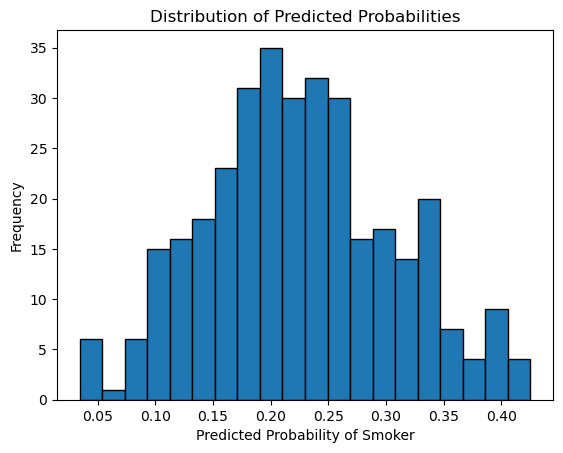

In [20]:
probs = mlp.predict_proba(X_test)[:, 1]

plt.hist(probs, bins=20, edgecolor="k")
plt.xlabel("Predicted Probability of Smoker")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities")
plt.show()


## First-Layer Weight Analysis

Although MLPs are not inherently interpretable, the magnitude of first-layer weights provides insight into which input features most strongly influence hidden representations.

Larger average absolute weights indicate features that contribute more heavily to learned nonlinear transformations.


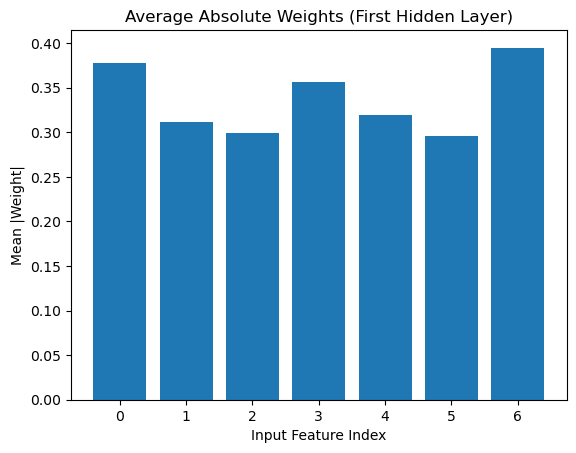

In [21]:
W1 = mlp.weights[0]
feature_importance = np.mean(np.abs(W1), axis=1)

plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Average Absolute Weights (First Hidden Layer)")
plt.xlabel("Input Feature Index")
plt.ylabel("Mean |Weight|")
plt.show()


## Probability Estimates

The model outputs class probabilities:

$$
P(\text{non-smoker}), \quad P(\text{smoker})
$$

These probabilities enable threshold tuning and risk-based decision making.


## Interpretation of Results

The Multilayer Perceptron achieves similar accuracy on both the training and test sets, indicating:

- **Stable convergence** under full-batch gradient descent  
- **Limited overfitting**, despite the use of multiple hidden layers  
- Evidence that the network has learned **generalizable nonlinear structure**

Unlike linear classifiers, the MLP models interactions between features (e.g., age × BMI × region) through nonlinear compositions of affine transformations and activation functions.


## Conclusion

This notebook demonstrated a fully from-scratch Multilayer Perceptron classifier applied to a real tabular dataset.

Key takeaways:
- The MLP successfully captures nonlinear interactions between features
- Training dynamics confirm correct gradient-based optimization
- Probability outputs provide meaningful confidence estimates
- The model generalizes well without overfitting

Overall, this implementation illustrates both the **mathematical foundations** and **practical behavior** of multilayer neural networks beyond linear classifiers.
